In [1]:
%env OMP_NUM_THREADS=4
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2

env: OMP_NUM_THREADS=4
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import sys
sys.path.append("../wilds_exps_utils/")

import torch
import numpy as np
import tqdm
import pickle
import copy
from types import SimpleNamespace
from wilds import get_dataset
from wilds.common.data_loaders import get_eval_loader
from wilds_configs import datasets as dataset_configs
from wilds.datasets.wilds_dataset import WILDSSubset
from wilds_models.initializer import initialize_model
import wilds_transforms as transforms

# from wilds_algorithms.initializer import infer_d_out

/home/shikai_q/anaconda3/envs/afr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

## Data and model

In [4]:
DATASET = 'civilcomments'

def get_data(args, wilds_config):
    full_dataset = get_dataset(dataset=DATASET, download=False, root_dir=args.root_dir)
    transform = transforms.initialize_transform(
            transform_name=wilds_config.transform,
            config=wilds_config,
            dataset=full_dataset,
            additional_transform_name=None,
            is_training=False)

    test_data = full_dataset.get_subset("test", transform=transform)
    val_data = full_dataset.get_subset("val", transform=transform)

    if args.dfr_reweighting_drop:
        train_data = full_dataset.get_subset("train", transform=transform)
        idx = train_data.indices.copy()
        rng = np.random.default_rng(args.dfr_reweighting_seed)
        rng.shuffle(idx)
        n_train = int((1 - args.dfr_reweighting_frac) * len(idx))
        val_idx = idx[n_train:]
        reweighting_data = WILDSSubset(
                full_dataset,
                indices=val_idx,
                transform=transform)
        del train_data
    else:
        reweighting_data = val_data
    return val_data, test_data, reweighting_data

In [5]:
# Just need the ds object for evaluation
DATASET = 'civilcomments'
seed = 2
args = SimpleNamespace(
    root_dir='/data/users/pavel_i/datasets/',
    batch_size=16,
    dfr_reweighting_drop=True,
    dfr_reweighting_seed=seed,
    dfr_reweighting_frac=0.2,
    ckpt_path=f'/home/pavel_i/projects/ssl_robustness/wilds_exps/logs/bert_civilcomments_dfrdrop_{seed}/civilcomments_seed:{seed}_epoch:last_model.pth'
)
wilds_config = SimpleNamespace(
    algorithm='ERM',
    load_featurizer_only=False,
    pretrained_model_path=None,
    **dataset_configs.dataset_defaults[DATASET],
)
wilds_config.model_kwargs = {}
wilds_config.model = 'bert-base-uncased'

val_data, test_data, reweighting_data = get_data(args, wilds_config)
reweighting_loader = get_eval_loader("standard", reweighting_data, batch_size=args.batch_size)
val_loader = get_eval_loader("standard", val_data, batch_size=args.batch_size)
test_loader = get_eval_loader("standard", test_data, batch_size=args.batch_size)

In [6]:
def load_model(args, wilds_config, d_out):
    model = initialize_model(config=wilds_config, d_out=d_out)
    ckpt_dict = torch.load(args.ckpt_path)
    model.load_state_dict({k[len('model.'):]: v for (k, v) in ckpt_dict['algorithm'].items()})
    model.cuda()
    model.eval()
    classifier = model.classifier
    model.classifier = torch.nn.Identity(model.classifier.in_features)
    return model, classifier

## Extract embeddings

In [7]:
def get_embeddings_predictions(feature_extractor, classifier, loader):
    all_embeddings, all_predictions, all_y_true, all_metadata = [], [], [], []
    # i = 0
    with torch.no_grad():
        for x, y_true, metadata in tqdm.tqdm(loader):
            embeddings = feature_extractor(x.cuda())
            predictions = torch.argmax(classifier(embeddings), axis=1)
            all_embeddings.append(embeddings.cpu())
            all_predictions.append(predictions.cpu())
            all_y_true.append(y_true.cpu())
            all_metadata.append(metadata)
    all_embeddings = torch.cat(all_embeddings, axis=0)
    all_predictions = torch.cat(all_predictions, axis=0)
    all_y_true = torch.cat(all_y_true, axis=0)
    all_metadata = torch.cat(all_metadata, axis=0)
    return all_embeddings, all_predictions, all_y_true, all_metadata

In [8]:
def save_emb(ckpt_path, seed, save_path):
        args = SimpleNamespace(
        root_dir='/data/users/pavel_i/datasets/',
        batch_size=16,
        dfr_reweighting_drop=True,
        dfr_reweighting_seed=seed,
        dfr_reweighting_frac=0.2,
        ckpt_path=ckpt_path
        )
        wilds_config = SimpleNamespace(
        algorithm='ERM',
        load_featurizer_only=False,
        pretrained_model_path=None,
        **dataset_configs.dataset_defaults[DATASET],
        )
        wilds_config.model_kwargs = {}
        wilds_config.model = 'bert-base-uncased'

        val_data, test_data, reweighting_data = get_data(args, wilds_config)
        bad_test_idx = 73529
        test_data.indices = np.delete(test_data.indices, bad_test_idx)
        reweighting_loader = get_eval_loader("standard", reweighting_data, batch_size=args.batch_size)
        val_loader = get_eval_loader("standard", val_data, batch_size=args.batch_size)
        test_loader = get_eval_loader("standard", test_data, batch_size=args.batch_size)

        d_out = 2
        feature_extractor, classifier = load_model(args, wilds_config, d_out)

        reweighting_embeddings, reweighting_predictions, reweighting_y, reweighting_metadata = get_embeddings_predictions(
                feature_extractor, classifier, reweighting_loader)
        val_embeddings, val_predictions, val_y, val_metadata = get_embeddings_predictions(
                feature_extractor, classifier, val_loader)
        test_embeddings, test_predictions, test_y, test_metadata = get_embeddings_predictions(
                feature_extractor, classifier, test_loader)
        torch.save(
        dict(
                e=reweighting_embeddings, y=reweighting_y, pred=reweighting_predictions, m=reweighting_metadata,
                test_e=test_embeddings, test_pred=test_predictions, test_y=test_y, test_m=test_metadata,
                val_e=val_embeddings, val_pred=val_predictions, val_y=val_y, val_m=val_metadata,
                w0 = classifier.weight.cpu(),
                b0 = classifier.bias.cpu()
        ),
        save_path
        )

In [10]:
from glob import glob
ckpt_dir = '/data/users/pavel_i/wilds_ckpts'
seeds = [0, 1, 2, 3, 4, 5]
for seed in seeds:
    ckpt_path = glob(f'{ckpt_dir}/bert_civilcomments_dfrdrop_{seed}/*last_model.pth')
    assert len(ckpt_path) == 1, f'Found {len(ckpt_path)} ckpts for seed {seed}, expected 1'
    ckpt_path = ckpt_path[0]
    save_path = f'emb/civil/{seed}.pt'
    save_emb(ckpt_path, seed, save_path)

AssertionError: Found 0 ckpts for seed 0, expected 1

## MethodName

In [ ]:
def plot_results(metrics):
    print("Early stopping by Val")
    earlystop_epoch = np.argmax(np.array(metrics.val_accs["wga"]))
    print(f"test WGA: {metrics.test_accs['wga'][earlystop_epoch]:.3f} at epoch {earlystop_epoch}") 
    # print(f"Early stopping test mean acc: {metrics.test_accs['mean_acc'][earlystop_epoch]:.3f} at epoch {earlystop_epoch}")
    print()
    
    print("Early stopping by Val Black")
    earlystop_epoch = np.argmax(metrics.val_accs["combined_wga"])
    print(f"test WGA: {metrics.test_accs['wga'][earlystop_epoch]:.3f} at epoch {earlystop_epoch}") 
    # print(f"Early stopping test mean acc: {metrics.test_accs['mean_acc'][earlystop_epoch]:.3f} at epoch {earlystop_epoch}")
    print()
    
    # 3 horizontal subplots
    fig, arr = plt.subplots(1, 3, figsize=(20, 5))
    arr[0].plot(metrics.losses, label="wxe")
    arr[0].plot(metrics.regs, label="Reg")
    arr[0].grid()
    arr[0].legend(loc="lower right")
    arr[0].set_xlabel("Epochs")
    arr[0].set_ylabel("Loss")

    arr[1].plot(metrics.test_accs["wga"], label="Test")
    arr[1].plot(metrics.reweighting_accs["wga"], label="Reweighting")
    arr[1].plot(metrics.val_accs["wga"], label="Validation")
    arr[1].grid()
    arr[1].legend(loc="lower right")
    arr[1].set_xlabel("Epochs")
    arr[1].set_ylabel("WGA")
    arr[1].set_ylim(0.5, 0.75)

    arr[2].plot(metrics.test_accs["mean_acc"], label="Test")
    arr[2].plot(metrics.reweighting_accs["mean_acc"], label="Reweighting")
    arr[2].plot(metrics.val_accs["mean_acc"], label="Validation")
    arr[2].grid()
    arr[2].legend(loc="lower right")
    arr[2].set_xlabel("Epochs")
    arr[2].set_ylabel("Mean Acc")

    # 4 horizontal subplots
    fig, arr = plt.subplots(2, 3, figsize=(20, 10))

    colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'orange']
    for attr, c in enumerate(colors):
        arr[0, 0].plot([ls[attr] for ls in metrics.loss_by_groups['toxic']], color=c)
        arr[0, 0].plot([ls[attr] for ls in metrics.loss_by_groups['non_toxic']], '--', color=c)
    arr[0, 0].grid()
    arr[0, 0].set_xlabel("Epochs")
    arr[0, 0].set_ylabel("Loss")
    arr[0, 0].legend(loc="lower right")

    for attr, c in enumerate(colors):
        arr[0, 1].plot([ls[attr] for ls in metrics.weights_by_groups['toxic']], color=c)
        arr[0, 1].plot([ls[attr] for ls in metrics.weights_by_groups['non_toxic']], '--', color=c)
    arr[0, 1].grid()
    arr[0, 1].set_xlabel("Epochs")
    arr[0, 1].set_ylabel("Weights")
    arr[0, 1].legend(loc="lower right")

    for attr, c in enumerate(colors):
        arr[0, 2].plot([ls[attr] for ls in metrics.confidence_by_groups['toxic']], color=c)
        arr[0, 2].plot([ls[attr] for ls in metrics.confidence_by_groups['non_toxic']], '--', color=c)
    arr[0, 2].grid()
    arr[0, 2].set_xlabel("Epochs")
    arr[0, 2].set_ylabel("Confidence")
    arr[0, 2].legend(loc="lower right")

    for attr, c in enumerate(colors):
        arr[1, 0].plot([ls[attr] for ls in metrics.test_accs['by_group_toxic']], color=c)
        arr[1, 0].plot([ls[attr] for ls in metrics.test_accs['by_group_nontoxic']], '--', color=c)
    arr[1, 0].plot(metrics.test_accs['combined_wga'], '-*', color='k')
    arr[1, 0].grid()
    arr[1, 0].set_xlabel("Epochs")
    arr[1, 0].set_ylabel("Test Acc")
    arr[1, 0].legend(loc="lower right")
    
    for attr, c in enumerate(colors):
        arr[1, 1].plot([ls[attr] for ls in metrics.val_accs['by_group_toxic']], color=c)
        arr[1, 1].plot([ls[attr] for ls in metrics.val_accs['by_group_nontoxic']], '--', color=c)
    arr[1, 1].plot(metrics.val_accs['combined_wga'], '-*', color='k')
    arr[1, 1].grid()
    arr[1, 1].set_xlabel("Epochs")
    arr[1, 1].set_ylabel("Val Acc")
    arr[1, 1].legend(loc="lower right")
    
    for attr, c in enumerate(colors):
        arr[1, 2].plot([ls[attr] for ls in metrics.reweighting_accs['by_group_toxic']], color=c)
        arr[1, 2].plot([ls[attr] for ls in metrics.reweighting_accs['by_group_nontoxic']], '--', color=c)
    arr[1, 2].plot(metrics.reweighting_accs['combined_wga'], '-*', color='k')
    arr[1, 2].grid()
    arr[1, 2].set_xlabel("Epochs")
    arr[1, 2].set_ylabel("Reweighting Acc")
    arr[1, 2].legend(loc="lower right")

In [7]:
class Metrics():
    def __init__(
            self, reweighting_metadata, test_metadata, val_metadata):
        
        self.n_cols = 8
        
        self.reweighting_metadata = reweighting_metadata
        self.test_metadata = test_metadata
        self.val_metadata = val_metadata
        
        self.reweighting_accs = self.get_init_accs()
        self.test_accs = self.get_init_accs()
        self.val_accs = self.get_init_accs()
        
        self.weights_by_groups = self.get_init_dict()
        self.loss_by_groups = self.get_init_dict()
        self.confidence_by_groups = self.get_init_dict()
        
        keys = ("toxic", "non_toxic")
        self.reweighting_group_sizes = dict(zip(keys, self._something_by_groups(
                torch.ones_like(reweighting_metadata[:, 0]), reweighting_metadata)))
        self.val_group_sizes = dict(zip(keys, self._something_by_groups(
                torch.ones_like(val_metadata[:, 0]), val_metadata)))
        self.test_group_sizes = dict(zip(keys, self._something_by_groups(
                torch.ones_like(test_metadata[:, 0]), test_metadata)))
        
        self.losses = []
        self.regs = []
        
#         self.weighted_acc = []
    
    @staticmethod
    def get_init_dict():
        return {'toxic': [], 'non_toxic': []}
    
    @staticmethod
    def get_init_accs():
        return {
            'mean_acc': [],
            'wga': [],
            'combined_wga': [],
            'by_group_toxic': [],
            'by_group_nontoxic': []
        }
    
    def _something_by_groups(self, something, metadata, mean=False):
        if mean: 
            return (
                [something[(metadata[:, i] == 1) & (metadata[:, -2] == v)].float().mean().item() for i in range(self.n_cols)]
                for v in [0, 1])
        else:
            return (
                [something[(metadata[:, i] == 1) & (metadata[:, -2] == v)].sum().item() for i in range(self.n_cols)]
                for v in [0, 1])
    
    def _update_weights_by_groups(self, weights):
        toxic, nontoxic = self._something_by_groups(
            weights, self.reweighting_metadata)
        self.weights_by_groups['toxic'].append(toxic)
        self.weights_by_groups['non_toxic'].append(nontoxic)
    
    def _update_loss_by_groups(self, ce):
        toxic, nontoxic = self._something_by_groups(
            ce, self.reweighting_metadata)
        self.loss_by_groups['toxic'].append(toxic)
        self.loss_by_groups['non_toxic'].append(nontoxic)
    
    def _update_confidence_by_groups(self, p_true):
        toxic, nontoxic = self._something_by_groups(
            p_true, self.reweighting_metadata, mean=True)
        self.confidence_by_groups['toxic'].append(toxic)
        self.confidence_by_groups['non_toxic'].append(nontoxic)
    
    def _update_accs(self, accs, metadata, results, predictions):
        toxic, nontoxic = self._something_by_groups(predictions == metadata[:, -2], metadata, mean=True)
        accs['mean_acc'].append(results[0]['acc_avg'])
        accs['wga'].append(results[0]['acc_wg'])
        accs['by_group_toxic'].append(toxic)
        accs['by_group_nontoxic'].append(nontoxic)
        all_accs = np.array([toxic, nontoxic])
        weights = np.array([0.56, 0.29, 0.15])[None, :]
        all_accs = np.hstack([
            all_accs[:, :3], 
            np.sum(all_accs[:, 3:6] * weights , axis=1, keepdims=True),
            all_accs[:, 6:]])
        accs['combined_wga'].append(np.min(all_accs))

   
    def update(
            self, weights, ce, p_true, loss, reg,
            reweighting_results, reweighting_predictions,
            test_results, test_predictions, 
            val_results, val_predictions
        ):
        
        self._update_weights_by_groups(weights)
        self._update_loss_by_groups(ce)
        self._update_confidence_by_groups(p_true)
        
        self._update_accs(self.reweighting_accs, self.reweighting_metadata, reweighting_results, reweighting_predictions)
        self._update_accs(self.test_accs, self.test_metadata, test_results, test_predictions)
        self._update_accs(self.val_accs, self.val_metadata, val_results, val_predictions)
        
        self.losses.append(loss.item())
        self.regs.append(reg.item())

    

In [ ]:
def get_wxe(*_):
    def confidence_wxe_fn(logits, y, weights):
        ce = torch.nn.functional.cross_entropy(logits, y, reduction='none')
        focal = weights * ce
        return focal.sum(), weights

    return confidence_wxe_fn

def compute_weights(logits, reweighting_y, gamma, balance_classes, base_weights=0.):
    with torch.no_grad():
        p = logits.softmax(-1)
        y_onehot = torch.zeros_like(logits).scatter_(-1, reweighting_y.unsqueeze(-1), 1)
        p_true = (p * y_onehot).sum(-1)
        weights = (-gamma * p_true).exp()
        if balance_classes:
            w1 = (reweighting_y == 0).sum()
            w2 = (reweighting_y == 1).sum()
            weights[reweighting_y == 0] *= w2 / w1
        weights = weights.detach()
        weights /= weights.sum()
        weights += base_weights / len(weights)
    return weights

In [ ]:
def train(
        reweighting_data, test_data, val_data,
        emb_dict, num_epochs, gamma, reg_coeff, lr=1e-2,
        base_weights=0.,
        balance_classes=False, plot=True, silent=False, combine_reweighting=False):

    del plot
    
    reweighting_embeddings = emb_dict['e'].cuda()
    reweighting_y = emb_dict['y'].cuda()
    reweighting_metadata = emb_dict['m'].cuda()
    test_embeddings = emb_dict['test_e'].cuda()
    test_y = emb_dict['test_y'].cuda()
    test_metadata = emb_dict['test_m'].cuda()
    val_embeddings = emb_dict['val_e'].cuda()
    val_y = emb_dict['val_y'].cuda()
    val_metadata = emb_dict['val_m'].cuda()
    w0 = emb_dict['w0'].cuda()
    b0 = emb_dict['b0'].cuda()
    
    if combine_reweighting:
        reweighting_embeddings = torch.cat([reweighting_embeddings, val_embeddings])
        reweighting_y = torch.cat([reweighting_y, val_y])
        reweighting_metadata = torch.cat([reweighting_metadata, val_metadata])
    print("Reweighting size:", len(reweighting_y))
    
    # Early stopping
    best_weights = {'w': w0, 'b': b0}
    best_wga = 0
#     trian_group_ratios = emb_dict['trian_group_ratios']

    last_layer_model = torch.nn.Linear(w0.shape[1], w0.shape[0], bias=True)
    last_layer_model.weight.data = w0.clone()
    last_layer_model.bias.data = b0.clone()
    last_layer_model.cuda()

    criterion = get_wxe(gamma)
    optimizer = torch.optim.SGD(last_layer_model.parameters(), lr=lr, weight_decay=0., momentum=0.)

    metrics = Metrics(reweighting_metadata, test_metadata, val_metadata)

    initial_logits = last_layer_model(reweighting_embeddings)
    weights = compute_weights(initial_logits, reweighting_y, gamma, balance_classes, base_weights=base_weights)

    for epoch in (pbar := tqdm.tqdm(range(num_epochs), disable=silent)):
        optimizer.zero_grad()
        logits = last_layer_model(reweighting_embeddings)
        loss, _ = criterion(logits, reweighting_y, weights)

        # L2 penalty for deviation from model.fc.weight and model.fc.bias
        reg = ((last_layer_model.weight - w0).pow(2).sum() + (last_layer_model.bias - b0).pow(2).sum())
        loss += reg_coeff * reg

        # additional infos
        with torch.no_grad():
            ce = torch.nn.functional.cross_entropy(logits, reweighting_y, reduction='none')
            p_true = (logits.softmax(-1) * torch.nn.functional.one_hot(reweighting_y, 2)).sum(-1)
            
            reweighting_predictions = torch.argmax(logits, -1)
            test_predictions = torch.argmax(last_layer_model(test_embeddings), -1)
            val_predictions = torch.argmax(last_layer_model(val_embeddings), -1)
            reweighting_results = reweighting_data.eval(
                    reweighting_predictions.cpu(), reweighting_y.cpu(), reweighting_metadata.cpu())
            test_results = test_data.eval(test_predictions.cpu(), test_y.cpu(), test_metadata.cpu())
            val_results = val_data.eval(val_predictions.cpu(), val_y.cpu(), val_metadata.cpu())
        
        metrics.update(
            weights, ce, p_true, loss, reg,
            reweighting_results, reweighting_predictions,
            test_results, test_predictions, 
            val_results, val_predictions
        )
        
        wga = metrics.val_accs['combined_wga'][-1]
        if wga > best_wga:
            best_wga = wga
            best_weights = {'w': last_layer_model.weight.data.clone(), 'b': last_layer_model.bias.data.clone()}

        nzw = (weights != 0).float().mean()
        loss.backward()
        # clip gradients
        torch.nn.utils.clip_grad_norm_(last_layer_model.parameters(), 1.)
        optimizer.step()
    #     scheduler.step()

        wga = metrics.reweighting_accs["wga"][-1]
        test_wga = metrics.test_accs["wga"][-1]
        pbar.set_description(f"Val BWGA: {best_wga:.3f}, TWGA: {test_wga:.3f}")

    return metrics, best_weights, best_wga

In [ ]:
def group_size_adjusted_wga(accs, sizes, i):
    at, st = np.array(accs["by_group_toxic"][i]), np.array(sizes["toxic"])
    an, sn = np.array(accs["by_group_nontoxic"][i]), np.array(sizes["non_toxic"])
    vt, vn = at - at**2, an - an**2
    lbs = np.concatenate([at - np.sqrt(vt / st), an - np.sqrt(vn / sn)])
    return np.min(lbs)

def wga(accs, i):
    at = np.array(accs["by_group_toxic"][i])
    an = np.array(accs["by_group_nontoxic"][i])
    return np.min(np.concatenate([at, an]))

## Hyper tuning

In [ ]:
seeds = [0,1,2,3,4]

gammas = [0., 0.001, 0.01, 0.1, 1., 10., 100.]
reg_coefs = [0]
lrs = [1e-2]

all_results = {}
all_metrics = {}

for seed in seeds:
    emb_dict = torch.load(f"emb/civil/{seed}.pt")
    for gamma in gammas:
        for reg_coef in reg_coefs:
            for lr in lrs:
                metrics, weights, val_wga = train(
                        reweighting_data, test_data, val_data,
                        emb_dict, num_epochs=50, gamma=gamma, reg_coeff=reg_coef, lr=lr,
                        balance_classes=True, plot=False, silent=False, combine_reweighting=False)
                all_results[(seed, gamma, reg_coef, lr)] = val_wga
                all_metrics[(seed, gamma, reg_coef, lr)] = metrics
                print(f"seed {seed}, gamma {gamma}, reg {reg_coef}, lr {lr}: {val_wga}")

In [8]:
def twga(metrics):
    earlystop_epoch = np.argmax(metrics.val_accs["combined_wga"])
    return metrics.test_accs['wga'][earlystop_epoch]

def twga_last(metrics):
    earlystop_epoch = -1
    return metrics.test_accs['wga'][earlystop_epoch]

def vwga(metrics):
    earlystop_epoch = np.argmax(metrics.val_accs["wga"])
    return metrics.val_accs['wga'][earlystop_epoch]

def vwga_last(metrics):
    earlystop_epoch = -1
    return metrics.val_accs['wga'][earlystop_epoch]

def vbwga(metrics):
    earlystop_epoch = np.argmax(metrics.val_accs["combined_wga"])
    return metrics.val_accs['combined_wga'][earlystop_epoch]

In [216]:
gammas = [0., 0.001, 0.01, 0.1, 1., 10., 100.]
reg_coefs = [0]
lrs = [1e-2]

all_results = {}
all_metrics = {}

for val_prop in [0.005]: #[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
    for seed in seeds:
        for shuffle_seed in [0, 21, 42]:
            rng = np.random.default_rng(shuffle_seed)
            emb_dict = torch.load(f"emb/civil/{seed}.pt")
            idx = np.arange(len(emb_dict['val_y']))
            rng.shuffle(idx)
            idx = idx[:int(val_prop * len(idx))]
            emb_dict['val_y'] = emb_dict['val_y'][idx]
            emb_dict['val_e'] = emb_dict['val_e'][idx]
            emb_dict['val_m'] = emb_dict['val_m'][idx]
            for gamma in gammas:
                for reg_coef in reg_coefs:
                    for lr in lrs:
                        metrics, weights, val_wga = train(
                                reweighting_data, test_data, val_data,
                                emb_dict, num_epochs=50, gamma=gamma, reg_coeff=reg_coef, lr=lr,
                                balance_classes=True, plot=False, silent=False, combine_reweighting=False)
                        all_results[(val_prop, shuffle_seed, seed, gamma, reg_coef, lr)] = val_wga
                        all_metrics[(val_prop, shuffle_seed, seed, gamma, reg_coef, lr)] = metrics
                        print(f"seed {seed}, gamma {gamma}, reg {reg_coef}, lr {lr}: {val_wga}")
# save all_metrics
# torch.save(all_metrics, "all_metrics.pt")

Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.421: 100%|██████████| 50/50 [00:04<00:00, 10.61it/s]


seed 0, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.420: 100%|██████████| 50/50 [00:04<00:00, 10.26it/s]


seed 0, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.419: 100%|██████████| 50/50 [00:04<00:00, 10.46it/s]


seed 0, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.399: 100%|██████████| 50/50 [00:04<00:00, 10.35it/s]


seed 0, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.250: 100%|██████████| 50/50 [00:04<00:00, 10.39it/s]


seed 0, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.150: 100%|██████████| 50/50 [00:04<00:00, 10.45it/s]


seed 0, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.132: 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]


seed 0, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.421: 100%|██████████| 50/50 [00:04<00:00, 10.40it/s]


seed 0, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.420: 100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


seed 0, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.419: 100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


seed 0, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.399: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]


seed 0, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.250: 100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


seed 0, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.150: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 0, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.132: 100%|██████████| 50/50 [00:04<00:00, 10.60it/s]


seed 0, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.421: 100%|██████████| 50/50 [00:04<00:00, 10.79it/s]


seed 0, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.420: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


seed 0, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.419: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


seed 0, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.399: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


seed 0, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.250: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


seed 0, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.150: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


seed 0, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.132: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 0, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.520: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


seed 1, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.520: 100%|██████████| 50/50 [00:04<00:00, 10.80it/s]


seed 1, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.517: 100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


seed 1, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.499: 100%|██████████| 50/50 [00:04<00:00, 10.98it/s]


seed 1, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.342: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


seed 1, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.087: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


seed 1, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.078: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


seed 1, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.520: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


seed 1, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.520: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


seed 1, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.517: 100%|██████████| 50/50 [00:04<00:00, 11.05it/s]


seed 1, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.499: 100%|██████████| 50/50 [00:04<00:00, 10.96it/s]


seed 1, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.342: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


seed 1, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.087: 100%|██████████| 50/50 [00:04<00:00, 11.02it/s]


seed 1, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.078: 100%|██████████| 50/50 [00:04<00:00, 11.02it/s]


seed 1, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.520: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


seed 1, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.520: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


seed 1, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.517: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


seed 1, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.499: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 1, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.342: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 1, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.087: 100%|██████████| 50/50 [00:04<00:00, 10.88it/s]


seed 1, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.078: 100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


seed 1, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.524: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 2, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.524: 100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


seed 2, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.523: 100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


seed 2, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.505: 100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


seed 2, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.347: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


seed 2, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.147: 100%|██████████| 50/50 [00:04<00:00, 10.78it/s]


seed 2, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.140: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


seed 2, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.524: 100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


seed 2, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.524: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 2, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.523: 100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


seed 2, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.505: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 2, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.347: 100%|██████████| 50/50 [00:04<00:00, 10.79it/s]


seed 2, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.147: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


seed 2, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.140: 100%|██████████| 50/50 [00:04<00:00, 10.97it/s]


seed 2, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.524: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


seed 2, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.524: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


seed 2, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.523: 100%|██████████| 50/50 [00:04<00:00, 10.80it/s]


seed 2, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.505: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


seed 2, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.347: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


seed 2, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.147: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


seed 2, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.140: 100%|██████████| 50/50 [00:04<00:00, 10.88it/s]


seed 2, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.467: 100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


seed 3, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.466: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


seed 3, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.463: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


seed 3, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.443: 100%|██████████| 50/50 [00:04<00:00, 10.98it/s]


seed 3, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.281: 100%|██████████| 50/50 [00:04<00:00, 10.94it/s]


seed 3, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.114: 100%|██████████| 50/50 [00:04<00:00, 10.94it/s]


seed 3, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.092: 100%|██████████| 50/50 [00:04<00:00, 10.99it/s]


seed 3, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.467: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


seed 3, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.466: 100%|██████████| 50/50 [00:04<00:00, 10.80it/s]


seed 3, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.463: 100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


seed 3, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.443: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 3, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.281: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


seed 3, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.114: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


seed 3, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.092: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 3, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.467: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


seed 3, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.466: 100%|██████████| 50/50 [00:04<00:00, 10.95it/s]


seed 3, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.463: 100%|██████████| 50/50 [00:04<00:00, 10.96it/s]


seed 3, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.443: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s]


seed 3, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.281: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s]


seed 3, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.114: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s]


seed 3, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.092: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s]


seed 3, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.516: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


seed 4, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.516: 100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


seed 4, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.512: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


seed 4, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.492: 100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


seed 4, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.351: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


seed 4, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.128: 100%|██████████| 50/50 [00:04<00:00, 10.88it/s]


seed 4, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.091: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 4, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.516: 100%|██████████| 50/50 [00:04<00:00, 10.94it/s]


seed 4, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.516: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


seed 4, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.512: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


seed 4, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.492: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


seed 4, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.351: 100%|██████████| 50/50 [00:04<00:00, 10.88it/s]


seed 4, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.128: 100%|██████████| 50/50 [00:04<00:00, 10.85it/s]


seed 4, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.091: 100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


seed 4, gamma 100.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.516: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


seed 4, gamma 0.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.516: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


seed 4, gamma 0.001, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.512: 100%|██████████| 50/50 [00:04<00:00, 10.88it/s]


seed 4, gamma 0.01, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.492: 100%|██████████| 50/50 [00:04<00:00, 10.94it/s]


seed 4, gamma 0.1, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.351: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


seed 4, gamma 1.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.128: 100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


seed 4, gamma 10.0, reg 0, lr 0.01: 0
Reweighting size: 53808


Val BWGA: 0.000, TWGA: 0.091: 100%|██████████| 50/50 [00:04<00:00, 10.88it/s]

seed 4, gamma 100.0, reg 0, lr 0.01: 0


In [10]:
all_metrics = torch.load("all_metrics.pt")
seeds = [0,1,2,3,4]
vps = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
test_wgas = []
for val_prop in vps:
    twgas = []
    for seed in seeds[:5]:
        seed_metrics = {k: v for (k, v) in all_metrics.items() if k[0] == val_prop and k[2] == seed}
        max_key = max(seed_metrics, key=lambda k: vbwga(seed_metrics[k]))
        twgas.append(twga(all_metrics[max_key]))
    test_wgas.append(twgas)
    print(val_prop, np.mean(twgas), np.std(twgas))

mean_wgas = [np.mean(twgas) for twgas in test_wgas]
std_wgas = [np.std(twgas) for twgas in test_wgas]
mean_wgas = np.array(mean_wgas) * 100
std_wgas = np.array(std_wgas) * 100
vps = np.array(vps)


0.005 0.5863492131233216 0.011733142041292027
0.01 0.6404367685317993 0.0565856852284793
0.02 0.6653104782104492 0.020678042578605102
0.05 0.6630322813987732 0.007298885650892849
0.1 0.6795891046524047 0.01394448129858912
0.2 0.682933509349823 0.008509875871770113
0.5 0.6872408509254455 0.008721285392665262
1 0.6872408509254455 0.008721285392665262


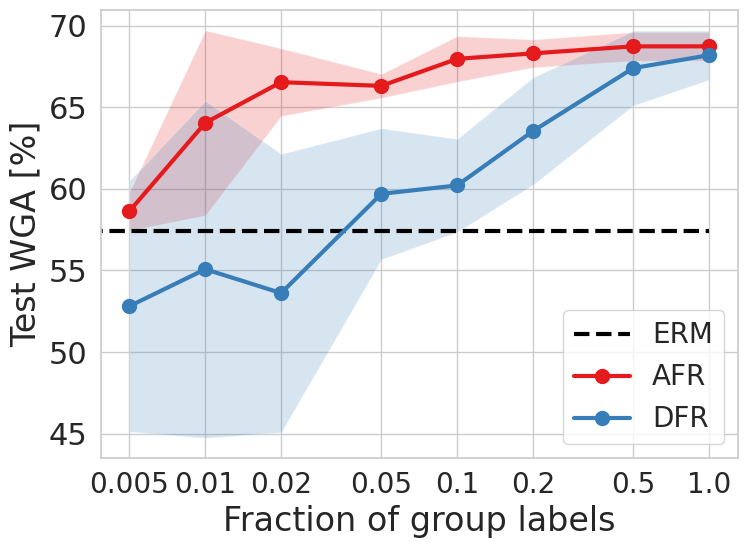

In [12]:
import pickle
from glob import glob
import os

dfr_vps = []
dfr_wgas = []
for file in glob('/home/shikai_q/deep_feature_reweighting/results/dfr_civil*.pkl'):
    with open(file, 'rb') as f:
        dfr = pickle.load(f)
    dfr_vps = dfr['val_fracs']
    dfr_wgas.append(dfr['test_wgas']) # (vp, seed)
dfr_vps = np.array(dfr_vps)
dfr_wgas = np.array(dfr_wgas) # (ckpt, vp, seed)
dfr_mean_wgas = np.mean(dfr_wgas, axis=(0, 2)) * 100 # (vp, )
dfr_std_wgas = np.std(dfr_wgas, axis=(0, 2)) * 100 # (vp, )

# plot mean and std against val_props
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")

plt.figure(dpi=100, figsize=(8, 6))
erm = 57.4
plt.plot([0, 1], [erm, erm], '--', label='ERM', color='black')

# plot nice-looking error bars as shaded region
plt.fill_between(vps, mean_wgas - std_wgas, mean_wgas + std_wgas, alpha=0.2)
plt.plot(vps, mean_wgas, label='AFR', marker='o', markersize=10)

plt.plot(dfr_vps[dfr_vps >= vps.min()], dfr_mean_wgas[dfr_vps >= vps.min()], label='DFR', marker='o', markersize=10)
plt.fill_between(dfr_vps[dfr_vps >= vps.min()], dfr_mean_wgas[dfr_vps >= vps.min()] - dfr_std_wgas[dfr_vps >= vps.min()], dfr_mean_wgas[dfr_vps >= vps.min()] + dfr_std_wgas[dfr_vps >= vps.min()], alpha=0.2)
plt.xlabel('Fraction of group labels')
# log x axis but label in linear
plt.xscale('log')
ticks = vps
plt.xticks(ticks, ticks, fontsize=20)

plt.ylabel('Test WGA [%]')
plt.legend(loc='lower right', fontsize=20)
plt.tight_layout()
plt.savefig('plots/civil_dfr_eff.pdf')

